# Thermodynamics
You'll measure and model the behavior of the temperature and mass (using a scale) of a venting canned air duster. Below are the equations you'll need to solve to estimate the temperature as a function of time and the mass loss as a function of time. You'll then compare your model to the data you collect by tying a rubber band around the trigger and measuring the temperature and mass loss as a function of time with the temperature probe and scale.

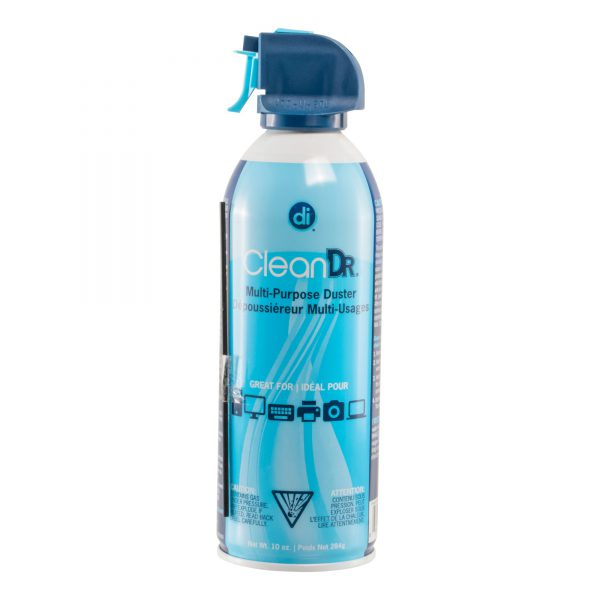

## Task 1: Review the below code

### First define model parameters
Found online by searching for property data for difluoroethane plus the parameters of the can. Estimated the heat and mass transfer coefficients.

In [1]:
#import needed packages
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt  
import pandas as pd

In [2]:
#model parameters for the venting of difluoroethane from a compressed container (all SI units)
lcan = 0.15 #150mm tall canister
dcan = 0.065 #diameter of can
harea = np.pi*lcan*dcan #150mm tall canister 65 mm diameter
marea = np.pi/4*dcan**2
Tsurr = 295 #surrounding temperature, K
Tref = 273 #reference temperature, K
factor = 0.9 #vent factor
gasConstant = 8.314 #J/mol/K
downstreamPressure = 12.2/14.5*1e5 #Pa, atmospheric pressure at test elevation approximately
gamma = 1.14 #ratio of specific heats of the gas
molecularWeight = 0.06605 #kg/mol
density = 2700 #kg/m3
CvVap = 59.58/gamma #J/mol/K, constant volume heat capacity
origmass = 10*0.0283495 #kg, amount initially present in the canister
Vol = lcan*np.pi/4*dcan**2#volume of the canister
#tuneable parameters
area = np.pi/4*0.0015**2 #orifice area for escaping gas,m2

In [3]:
origmass

0.283495

### Now specify the functions needed: 
- Venting through an orifice (mach number needed), 
- Saturated vapor pressure, 
- Equation of State,
- Derivatives of moles and temperature (based on energy and mole balances)

In [4]:
#specify mach number function
def mach(upstreamPressure):
  tau = 500
  transition = np.tanh((upstreamPressure-downstreamPressure)/tau)/2+0.5
  ratio = transition*upstreamPressure/downstreamPressure + (1-transition)*downstreamPressure/upstreamPressure
  multiplier = 1*transition-1*(1-transition)
  mach_abs=np.sqrt(2/(gamma-1)*(ratio**((gamma-1)/gamma)-1))
  return min(1.,mach_abs)*multiplier

def dndtvent(pressure,temperature): #rate of change of moles from a pressurized scenario
  #calculate the mach number
  machno = mach(pressure)
  if downstreamPressure>pressure:
    drivingPressure = downstreamPressure
  else:
    drivingPressure = pressure
  dndt = drivingPressure*area*factor*np.sqrt(gamma/(gasConstant*temperature*molecularWeight))*machno*(1+(gamma-1)/2*machno**2)**((gamma+1)/(2-2*gamma))
  return dndt

def psat(temperature): #saturated vapor pressure using Antione's equation
  constants = [4.23406,896.171,-34.714]
  return (10**(constants[0]-(constants[1]/(temperature+constants[2]))))*1e5
  
def pressure(molesLiq,molesVap,tempVap): #gas pressure from eos, assumed ideal
  return molesVap*gasConstant*tempVap/(Vol-molesLiq*molecularWeight/density) 

### Include in the model the two phases with heat transfer
- Additional parameters
- Heat transfer
- Psat and mass transfer functions
- Derivatives of the moles and temperature are evaluated for each phase

In [5]:
hvap = 22000 #heat of vaporation, J/mol
CvLiq = 118.4 #Cp,J/mol/K, assuming the constant volume heat capcity is very close to this
#tuneable parameters
hcv = 40 #convective heat transfer coefficient, J/m2/K
km = 0.05 #mass transfer coefficient, m/s

In [6]:
#include heat transfer
def heatIn(temperature): #heat into the volume
  return harea/2*hcv*(Tsurr-temperature) #1/2 factor for half the area for each of liq or vap

#include mass transfer between the liquid and the gas
def noutLiq(molesLiq,molesVap,tempLiq,tempVap): #mass transfer from the liquid surface
  return km*marea*(psat(tempLiq)/(gasConstant*tempLiq)-pressure(molesLiq,molesVap,tempVap)/(gasConstant*tempVap))

In [7]:
def derivatives(molesLiq,molesVap,tempLiq,tempVap):
  noutL = noutLiq(molesLiq,molesVap,tempLiq,tempVap); noutV = dndtvent(pressure(molesLiq,molesVap,tempVap),tempVap)
  dndtLiq = -noutL
  dndtVap = noutL-noutV
  dTdtLiq = (heatIn(tempLiq)-noutL*hvap+noutL*CvLiq*(tempLiq-Tref))/(molesLiq*CvLiq)
  dTdtVap = ((noutV-noutL)*CvVap*(tempVap-Tref)+noutL*CvVap*gamma*(tempLiq-Tref)-noutV*CvVap*gamma*(tempVap-Tref)+heatIn(tempVap))/(molesVap*CvVap)
  return [dndtLiq,dndtVap,dTdtLiq,dTdtVap]

## Task 2: Complete the simulation with the above functions 
You'll obtain the simulated temperature and mass of the liquid in the can as a function of time. You'll add an integration step to obtain the variables from their derivatives.

## Task 3: Obtain Experimental Data 
Use the ESP32 and K-type Thermocouple and a scale to measure the temperature and mass as the difluoroethane vents.

You can review the safety of such a procedure by reviewing this document: [Safety calculations](https://github.com/clint-bg/demos/blob/main/ventingVapor/difluoroethane_concentration.ipynb)

## Task 4: Aspen Plus Simulation
Simulate with Aspen Plus a separator with difluoroethane (CAS 75-37-6) where the inlet pressure is 85 kPa and the vapor fraction is 0. Estimate the heat transferred to the can (separator) such that the mass loss mimics the mass loss rate from the experiment. 

## Task 5: Complete the Documentation
Document your experience with the above tasks in a writeup according to the case study documentation.